In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from collections import Counter

# Exploratory Data Analysis (EDA) notebook for the IAM Handwriting Database.

The IAM Handwriting Database is a publicly accessible and freely available dataset that is widely used for research purposes. It contains handwritten forms, text lines, sentences, and words, providing a rich resource for studying handwriting recognition, optical character recognition (OCR), and related fields.

Dataset Description:
The IAM Handwriting Database is hierarchically structured into different categories. The dataset includes the following components:

Forms: This category contains form images, where each image represents a complete handwritten form. The forms are named following the LOB Corpus naming scheme, such as "a01-122.png".

Text Lines: The text lines category contains individual lines of text extracted from the form images. Each line is saved as a separate image, following a similar naming convention as the forms.

Sentences: This category contains sentences, with one sentence corresponding to each text line image. The sentences provide additional context and can be used for higher-level analysis.

Words: This category includes individual words extracted from the text lines. Similar to text lines, each word is saved as an image.

ASCII and XML: These categories contain meta-information about the forms, lines, sentences, and words in ASCII and XML formats, respectively. They provide summarized information about the dataset, including labels, coordinates, and other relevant details.

### Objective of the EDA

The primary objective of this exploratory data analysis (EDA) is to gain valuable insights into the IAM Handwriting Database and explore its inherent characteristics. This analysis aims to address various key aspects, including:

Initial Checks: Conducting preliminary assessments to identify any anomalous or illogical word lengths within the dataset.

Words Length Analysis: Analyzing the distribution of word lengths within the dataset to uncover patterns or deviations from the norm.

Character Frequency: Examining the frequency of individual characters to understand their prevalence and significance within the dataset.

Characters Analysis by Categories: Categorizing characters based on predefined categories, such as letters, spaces, numbers, and punctuation, to gain a deeper understanding of the character composition within the dataset.

Words Frequency Analysis: Investigating the frequency distribution of words to identify commonly occurring terms and potential outliers.

By addressing these key areas, we aim to gain comprehensive insights into the IAM Handwriting Database, enabling a better understanding of its characteristics and facilitating subsequent analysis and modeling tasks.

The EDA is splited into two parts: the first part focuses on analyzing the data from the labels, while the second part covers the analysis of the data from the images.

### Analysis on the data from the labels

Importing the labels

In [2]:
with open("lines.txt", "r") as f:
    lines = f.readlines()
    split_lines = [line.split(" ", 8) for line in lines]
df = pd.DataFrame(split_lines)
df.iloc[:,-1].replace(to_replace=[r'\|', r'\n$'], value=[' ', ''], regex=True, inplace=True)

In [3]:
column_mapping = {
    0: 'form_id',
    1: 'result_segmentation',
    2: 'graylevel',
    3: 'num_components',
    4: 'bounding_box_x',
    5: 'bounding_box_y',
    6: 'bounding_box_w',
    7: 'bounding_box_h',
    8: 'transcription'
}

df = df.rename(columns=column_mapping)

In [4]:
df.sample(5)

,form_id,result_segmentation,graylevel,num_components,bounding_box_x,bounding_box_y,bounding_box_w,bounding_box_h,transcription
100,a01-014-03,ok,182,15,384,1224,1745,130,""" We want to discuss what to do if the"
2858,c02-000-00,ok,155,13,344,900,1872,106,"AFTER ten days of intermittent , near fatal"
2143,b03-098-00,ok,182,19,368,746,1688,128,The press and the broadcasting authorities are
3726,c04-139-01,ok,187,40,321,939,1898,109,such as a chair and a motor-car . The idea is ...
7294,g06-031g-00,ok,182,21,339,721,1685,117,' What a frightful event ! ' he wrote . ' I tr...


It is interesting to see in the example that the position of each image in the Form is added. With that we can generate an ideal extraction.

For a better interpretation of the data, we add features to counding char, spaces and words. Below are the features generation functions.

In [5]:
def count_characters(string):
    return len(string)

In [6]:
def count_spaces(string):
    return string.count(' ')

In [7]:
def count_words(string):
    return len(string.split())

In [8]:
def create_word_length_dict(text):
    words = text.split()
    length_dict = {}
    for word in words:
        length = len(word)
        if length in length_dict:
            length_dict[length] += 1
        else:
            length_dict[length] = 1
    return length_dict

Now we are going to add the features to our dataset.

In [9]:
df['CharacterCount'] = df['transcription'].apply(count_characters)

In [10]:
df['SpaceCount'] = df['transcription'].apply(count_spaces)

In [11]:
df['WordCount'] = df['transcription'].apply(count_words)

In [12]:
df['WordLengthDict'] = df['transcription'].apply(create_word_length_dict)

#### Performing initial checks on the length of words to detect illogical values

In [13]:
WordLengthDict_total = defaultdict(int)

for dictionary in df['WordLengthDict']:
    for key, value in dictionary.items():
        WordLengthDict_total[key] += value

WordLengthDict_total = dict(WordLengthDict_total)

In [14]:
WordLengthDict_total

{1: 18123,
 4: 16469,
 2: 17609,
 3: 22088,
 9: 3782,
 10: 2443,
 6: 8322,
 5: 11275,
 7: 7336,
 8: 5212,
 14: 172,
 11: 1310,
 12: 760,
 15: 46,
 16: 37,
 13: 368,
 18: 1,
 17: 8,
 19: 4,
 21: 2,
 20: 1,
 53: 1}

In [15]:
WordLength_to_search = 53
WordLength_to_search_rows = df[df['WordLengthDict'].apply(lambda x: WordLength_to_search in x.keys())]
WordLength_to_search_rows

,form_id,result_segmentation,graylevel,num_components,bounding_box_x,bounding_box_y,bounding_box_w,bounding_box_h,transcription,CharacterCount,SpaceCount,WordCount,WordLengthDict
12417,p02-109-01,err,175,16,371,766,546,38,----------------------------------------------...,53,0,1,{53: 1}


Doing a visual review of the values, we see that there is a length of 53 which is not logical. We can see the transcription of this sample is not a text. The sample will drop. 

In [16]:
WordLength_to_search_indices = WordLength_to_search_rows.index

In [17]:
df.shape

(13353, 13)

In [18]:
df.drop(WordLength_to_search_rows.index, inplace=True)

In [19]:
df.shape

(13352, 13)

We check the shape before and after deletion to make sure we are deleting a single swatch.

In [20]:
del WordLengthDict_total[53]

#### Presentation of dataset information

In [21]:
df.sample(5)

,form_id,result_segmentation,graylevel,num_components,bounding_box_x,bounding_box_y,bounding_box_w,bounding_box_h,transcription,CharacterCount,SpaceCount,WordCount,WordLengthDict
9739,k03-144-02,err,191,27,342,1055,1880,137,"Party 's very restless , you know . ' ' It",42,10,11,"{5: 1, 2: 2, 4: 2, 8: 1, 1: 4, 3: 1}"
1928,b01-044-04,ok,194,31,350,1477,1791,116,should . Germany exports much more than she im...,53,9,10,"{6: 1, 1: 2, 7: 3, 4: 3, 3: 1}"
2094,b02-045-02,ok,173,41,350,1085,1569,107,very unlikely ; if Formula Three restores the ...,54,8,9,"{4: 1, 8: 3, 1: 1, 2: 1, 7: 1, 5: 1, 3: 1}"
6590,g03-064-01,ok,191,18,403,839,1812,145,"with a book on the life of Marx ,",33,8,9,"{4: 4, 1: 2, 2: 2, 3: 1}"
1378,a05-013-01,ok,176,26,366,938,1713,64,approval . Mr. Watkinson remains con-,37,5,6,"{8: 1, 1: 1, 3: 1, 9: 1, 7: 1, 4: 1}"


In [22]:
print(f'Total lines in the datasets is: {len(df)}')

Total lines in the datasets is: 13352


In [23]:
datasets_total_words = df['WordCount'].sum()

print(f'Total words in the datasets is: {datasets_total_words}')

Total words in the datasets is: 115368


Reviewing the number of records, we find 13,352 lines and 115,368 words. We understand that it is an acceptable number for the model we want to design.

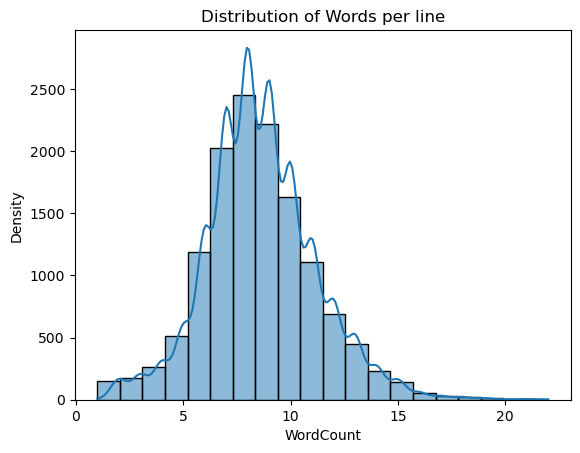

In [24]:
sns.histplot(df['WordCount'], bins=20, kde=True)
plt.xlabel('WordCount')
plt.ylabel('Density')
plt.title('Distribution of Words per line')
plt.show()

We discovered that the distribution of word count per line follows a normal distribution, with an average of 8 words per line. However, we should consider the potential bias towards smaller values. This bias is logical since the text is typically written from left to right, and not all lines are fully completed.

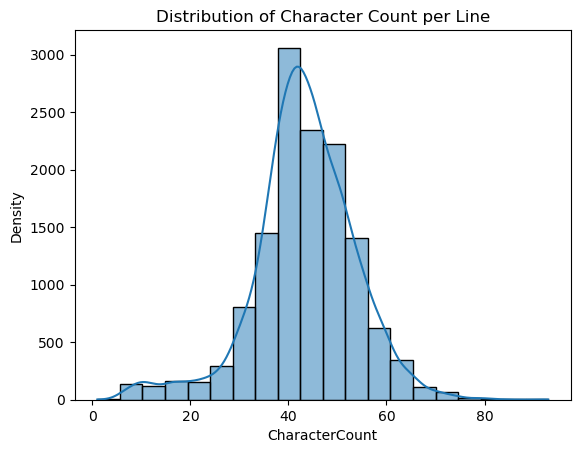

In [25]:
sns.histplot(df['CharacterCount'], bins=20, kde=True)
plt.xlabel('CharacterCount')
plt.ylabel('Density')
plt.title('Distribution of Character Count per Line')
plt.show()


We observed that the distribution of character count per line follows a normal distribution, but with a distinct shift towards the left. This finding is expected since not all lines are fully completed.

#### Words length analysis

In [26]:
WordLengthDict_total_keys = list(WordLengthDict_total.keys())
WordLengthDict_total_values = list(WordLengthDict_total.values())

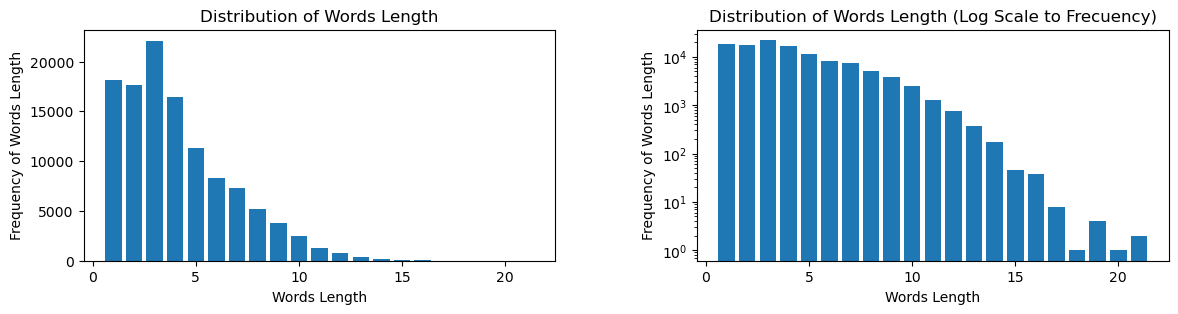

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))

# Plot the bar chart on the first subplot (left side)
axes[0].bar(WordLengthDict_total_keys, WordLengthDict_total_values)
axes[0].set_xlabel('Words Length')
axes[0].set_ylabel('Frequency of Words Length')
axes[0].set_title('Distribution of Words Length')

# Plot the bar chart on the second subplot (right side)
axes[1].bar(WordLengthDict_total_keys, WordLengthDict_total_values)
axes[1].set_xlabel('Words Length')
axes[1].set_ylabel('Frequency of Words Length')
axes[1].set_title('Distribution of Words Length (Log Scale to Frecuency)')
axes[1].set_yscale('log')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()

We expected Log-Normal Distribution for word length, and that's it. This indicates that we would be facing quality information to move forward with the development of the model.

#### Charcater frequency

To analyze the frequency of the characters we need to generate another feature with a dictionary of the frequency of each character in each line. Below is the function and the addition of the feature to our dataset.

In [28]:
def create_char_frequency_dict(text):
    frequency_dict = {}
    for char in text:
        if char in frequency_dict:
            frequency_dict[char] += 1
        else:
            frequency_dict[char] = 1
    return frequency_dict

In [29]:
df['CharFrequencyDict'] = df['transcription'].apply(create_char_frequency_dict)

In [30]:
char_total_freq = defaultdict(int)

for dictionary in df['CharFrequencyDict']:
    for key, value in dictionary.items():
        char_total_freq[key] += value

char_total_freq = dict(char_total_freq)

In [31]:
char_total_freq

{'A': 1257,
 ' ': 102016,
 'M': 1144,
 'O': 469,
 'V': 171,
 'E': 675,
 't': 39972,
 'o': 33343,
 's': 27867,
 'p': 8253,
 'r': 27516,
 '.': 6224,
 'G': 661,
 'a': 35849,
 'i': 30300,
 'k': 2819,
 'e': 56911,
 'l': 18036,
 'f': 10006,
 'm': 10642,
 'n': 31027,
 'g': 8653,
 'y': 8264,
 'L': 638,
 'b': 6803,
 'u': 12203,
 'P': 722,
 'd': 17952,
 'w': 8808,
 'c': 11823,
 'h': 25244,
 'F': 489,
 'j': 423,
 'W': 728,
 ',': 5629,
 'x': 785,
 '0': 431,
 'T': 1652,
 '-': 1492,
 "'": 1987,
 'v': 4528,
 'B': 854,
 'H': 988,
 '"': 1629,
 'S': 1064,
 '1': 494,
 '9': 179,
 '5': 157,
 '8': 118,
 '3': 174,
 '#': 79,
 'q': 370,
 'N': 711,
 'R': 606,
 'D': 569,
 'K': 163,
 'U': 189,
 'I': 1600,
 '(': 203,
 '2': 209,
 ')': 200,
 'C': 750,
 '4': 118,
 ':': 165,
 'Y': 227,
 'J': 181,
 '7': 64,
 ';': 204,
 '6': 121,
 'z': 205,
 'Z': 10,
 '?': 259,
 '*': 14,
 'Q': 16,
 'X': 8,
 '!': 226,
 '/': 16,
 '&': 55,
 '+': 9}

We take a first look at the values. They seem to be logical. We continue to plot for a better understanding.

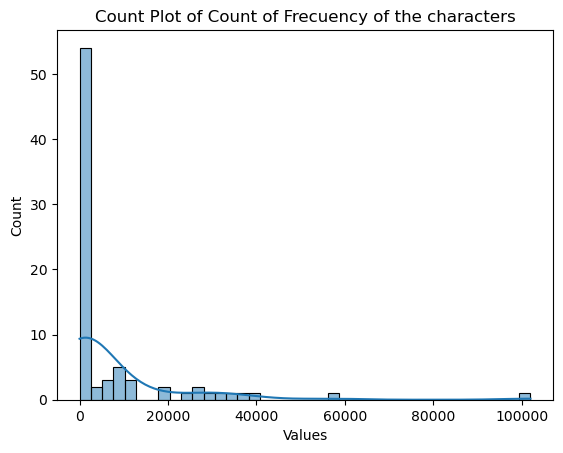

In [32]:
char_total_freq_values = list(char_total_freq.values())

num_bins = 40

sns.histplot(char_total_freq_values, bins=num_bins, kde=True)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count Plot of Count of Frecuency of the characters')
plt.show()

In [33]:
print(f'Total of different chars: {len(char_total_freq)}')

Total of different chars: 79


We see that we have 79 different characters. About 55 characters have a low frequency, below 2000 times, while the rest have different levels of frequency. In this case the space is counted as a character and logically has a high frequency.

We add interesting information for the most common and least common characters.

In [34]:
sorted_items = sorted(char_total_freq.items(), key=lambda x: x[1], reverse=True)

In [35]:
print('Top 10 frequent chars:')

for key, value in sorted_items[:10]:
    print(f"Char: '{key}' / Count: {value}")

Top 10 frequent chars:
Char: ' ' / Count: 102016
Char: 'e' / Count: 56911
Char: 't' / Count: 39972
Char: 'a' / Count: 35849
Char: 'o' / Count: 33343
Char: 'n' / Count: 31027
Char: 'i' / Count: 30300
Char: 's' / Count: 27867
Char: 'r' / Count: 27516
Char: 'h' / Count: 25244


In [36]:
print('10 least frequent chars:')

for key, value in sorted_items[-10:]:
    print(f"Char: '{key}' / Count: {value}")

10 least frequent chars:
Char: '4' / Count: 118
Char: '#' / Count: 79
Char: '7' / Count: 64
Char: '&' / Count: 55
Char: 'Q' / Count: 16
Char: '/' / Count: 16
Char: '*' / Count: 14
Char: 'Z' / Count: 10
Char: '+' / Count: 9
Char: 'X' / Count: 8


The presence of the characters exposed in the top and least 10 ranking is logical. This indicates that our train set is representative. Because there are numbers in the less common characters, we can understand that letter characters predominate in texts.

#### Characters analysis by categories

In [37]:
char_categories = {}

for char, frequency in char_total_freq.items():
    if char == ' ':
        char_categories[char] = 'Space'
    elif char.isalpha():
        char_categories[char] = 'Letter'
    elif char.isdigit():
        char_categories[char] = 'Number'
    else:
        char_categories[char] = 'Punctuation'

In [38]:
category_totals = {}

for char, frequency in char_total_freq.items():
    category = char_categories[char]
    category_totals[category] = category_totals.get(category, 0) + frequency

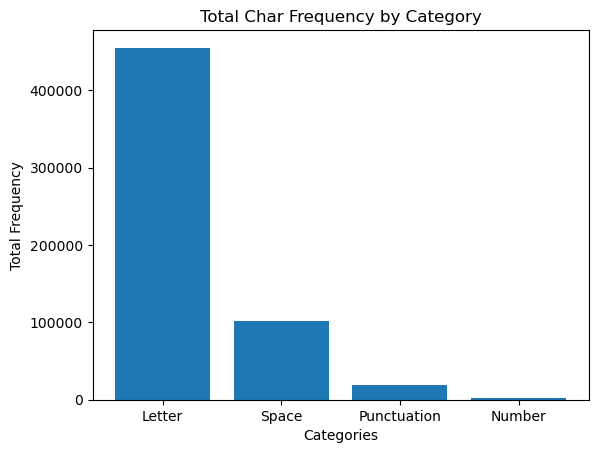

In [39]:
categories = list(category_totals.keys())
frequencies = list(category_totals.values())

plt.bar(categories, frequencies)
plt.xlabel('Categories')
plt.ylabel('Total Frequency')
plt.title('Total Char Frequency by Category')

plt.show()

We reached the conclusion that we can confirm the low presence of numbers. The proportion of the rest of the character categories is as expected.

#### Words frequency analysis

In [40]:
all_sentences = ' '.join(df['transcription'].astype(str).tolist())

words = all_sentences.split()

word_frequencies = Counter(words)

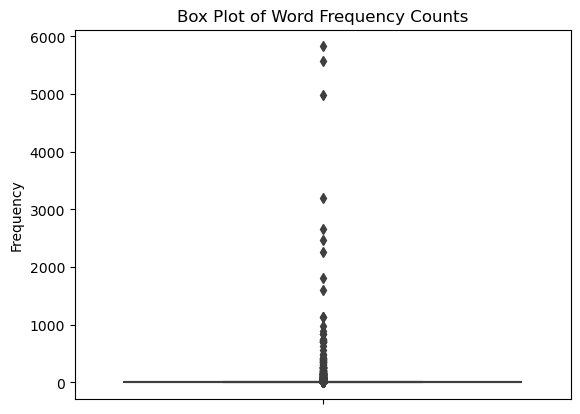

In [41]:
word_frequencies_values = list(word_frequencies.values())

sns.boxplot(y=word_frequencies_values)

plt.ylabel('Frequency')
plt.title('Box Plot of Word Frequency Counts')
plt.show()

We can see that there are many outliers with very high values, that is, many words are repeated many times.

These are the words that are repeated more than 1000 times

In [42]:
print('Top 10 frequent words:')

for word, frequency in word_frequencies.items():
    if frequency > 1000:
        print(word, ':', frequency)

Top 10 frequent words:
to : 2651
a : 2264
of : 3192
. : 4984
the : 5826
and : 2475
, : 5570
that : 1127
" : 1599
in : 1802
was : 1135


We see that some punctuations are taken as words. We will take advantage of the categories of characters raised above to discard them to analyze only words.

In [43]:
word_frequencies_under_no_punctations = {word: frequency for word, frequency in word_frequencies.items() if char_categories.get(word, '') != 'Punctuation'}

In [44]:
len(word_frequencies), len(word_frequencies_under_no_punctations), len(word_frequencies)-len(word_frequencies_under_no_punctations)

(13545, 13531, 14)

We can see that 14 words that were actually punctuations were removed

We plot with different maximum frequency value the count value of the frequencies of the words.

In [45]:
word_frequencies_under_500 = {word: frequency for word, frequency in word_frequencies_under_no_punctations.items() if frequency < 500}
word_frequencies_values_under_500 = list(word_frequencies_under_500.values())

In [46]:
word_frequencies_under_200 = {word: frequency for word, frequency in word_frequencies.items() if frequency < 200}
word_frequencies_values_under_200 = list(word_frequencies_under_200.values())

In [47]:
word_frequencies_under_50 = {word: frequency for word, frequency in word_frequencies.items() if frequency < 50}
word_frequencies_values_under_50 = list(word_frequencies_under_50.values())

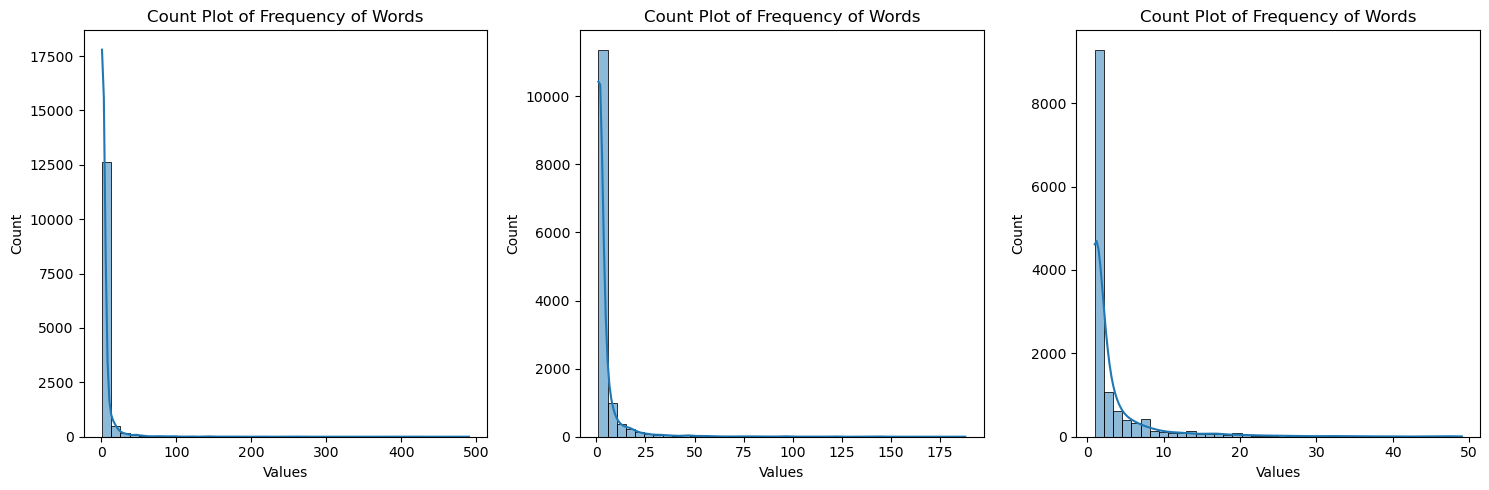

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(word_frequencies_values_under_500, bins=num_bins, kde=True, ax=axes[0])
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Count')
axes[0].set_title('Count Plot of Frequency of Words')

sns.histplot(word_frequencies_values_under_200, bins=num_bins, kde=True, ax=axes[1])
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Count')
axes[1].set_title('Count Plot of Frequency of Words')

sns.histplot(word_frequencies_values_under_50, bins=num_bins, kde=True, ax=axes[2])
axes[2].set_xlabel('Values')
axes[2].set_ylabel('Count')
axes[2].set_title('Count Plot of Frequency of Words')

plt.tight_layout()
plt.show()

Finally, the analysis reveals that words with high frequencies are quite rare. This observation suggests that forecasting results using a word-based model may not yield optimal outcomes. Considering this, an alternative approach could involve using the entire lines of text as inputs for better performance and accuracy.